In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import pyreadr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
bilstm_data = pd.read_csv('./data/bilstm_surprisals.txt', sep='\t')
bilstm_data['Token'] = bilstm_data['Token'].str.strip('▁')
bilstm_data

,Steps,Token,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples
0,100,horse,19983,14.895349,0.004593,0.000000,512
1,100,tummy,18820,14.891188,0.002782,0.000000,440
2,100,stuck,22680,14.909454,0.004160,0.000000,512
3,100,church,20880,14.900540,0.002751,0.000000,512
4,100,it,1410,14.787140,0.005986,0.000000,512
...,...,...,...,...,...,...,...
127083,1000000,deer,72,9.663195,3.975208,0.052734,512
127084,1000000,egg,56,8.933968,4.905982,0.148438,512
127085,1000000,oven,10,7.006861,4.581110,0.195312,512
127086,1000000,clock,2,5.743079,5.174706,0.419922,512


In [3]:
word_df = bilstm_data[bilstm_data['Token'] == 'eat']
word_steps = np.log(word_df['Steps'].values)

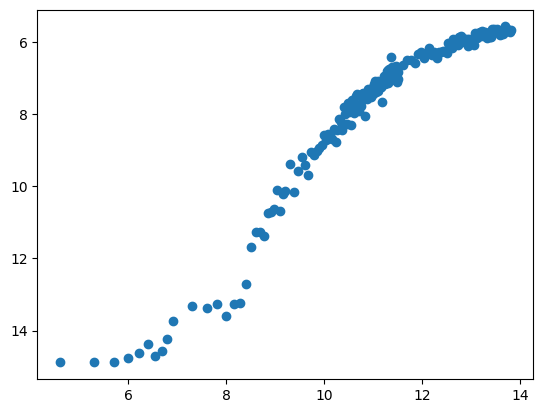

In [4]:
plt.gca().invert_yaxis()
plt.scatter(np.log(word_df['Steps'].values), word_df['MeanSurprisal'].values)

In [5]:
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y.ravel())

# If we model AoA as the surprisal of the model for a word after training 
def get_last_surprisal(word):
    word_df = bilstm_data[bilstm_data['Token'] == word]
    word_surprisal = word_df['MeanSurprisal'].values
    return word_surprisal[-1]

# If we model AoA as the number of steps at which the model reaches 50% of the
# suprisal for that word compared to the lowest it will reach once trained.
# fits a sigmpoid as per: https://arxiv.org/pdf/2110.02406.pdf
def get_model_aoa(word):
    word_df = bilstm_data[bilstm_data['Token'] == word]
    word_steps = np.log(word_df['Steps'].values)
    word_surprisal = word_df['MeanSurprisal'].values
    p0 = [max(word_surprisal), np.median(word_surprisal), 1, min(word_surprisal)] # this is an mandatory initial guess

    try:
        popt, pcov = curve_fit(sigmoid, word_steps.reshape(-1, 1), word_surprisal, p0, method='dogbox')
    except:
        return -1
    v_50 = word_surprisal[-1] + (word_surprisal[0] - word_surprisal[-1])/2
    
    aoa = popt[1] - (1/popt[2]) * np.log(-1 + popt[0]/(v_50 - popt[3]))
    
    return aoa

In [6]:
word_aoa = {}
for word in set(bilstm_data['Token']):
    aoa = get_model_aoa(word)
    word_aoa[word] = aoa

/var/folders/yd/tb591z796mv2qrjpzyyx3tjh0000gn/T/ipykernel_66630/2712548579.py:28: RuntimeWarning: invalid value encountered in log
  aoa = popt[1] - (1/popt[2]) * np.log(-1 + popt[0]/(v_50 - popt[3]))


In [7]:
# deleting words for which fitting sigmoid failed
del_words = []
for word in word_aoa:
    if str(word_aoa[word]) == 'nan':
        del_words.append(word)
for word in del_words:
    del word_aoa[word]

16.456542350002366 14.89534854888916


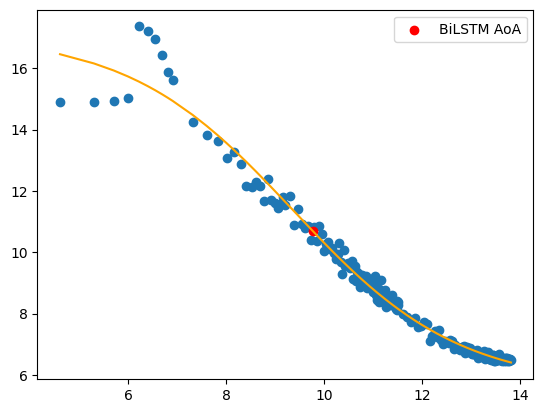

In [8]:
# Visualising a sigmoid curve

word_df = bilstm_data[bilstm_data['Token'] == 'horse']
word_steps = np.log(word_df['Steps'].values)
word_surprisal = word_df['MeanSurprisal'].values
p0 = [max(word_surprisal), np.median(word_surprisal), 1, min(word_surprisal)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, word_steps.reshape(-1, 1), word_surprisal, p0, method='dogbox')

v_50 = word_surprisal[-1] + (word_surprisal[0] - word_surprisal[-1])/2

aoa = popt[1] - (1/popt[2]) * np.log(-1 + popt[0]/(v_50 - popt[3]))

print(sigmoid(word_steps[0], *popt)[0], word_surprisal[0])
plt.scatter(word_steps, word_surprisal)
plt.scatter(aoa, sigmoid(aoa, *popt), color='red', label='BiLSTM AoA')
plt.plot(word_steps, sigmoid(word_steps, *popt), color='orange')
plt.legend()

#### We could use the above AoAs using this curve fit, but the paper's code has provided the data of the AoAs they obtained with the above method directly, so we test with that

In [9]:
bilstm_midpoint_surprisals = pd.read_csv('./data/bilstm_aoa_midpoint.txt', sep='\t')

In [10]:
bilstm_midpoint_surprisals

,Token,LmAoA,LmCutoff,MaxSurprisal,MinSurprisal,ParamUpper,ParamLower,ParamXmid,ParamScale
0,a,2.329342,12.915168,14.736223,0.939625,24.902178,0.928158,2.329342,0.576778
1,about,3.168829,9.910866,15.072885,2.030145,17.900674,1.921058,3.168829,0.607426
2,above,3.965837,10.302863,14.915832,5.505376,15.434107,5.171619,3.965837,0.648469
3,after,3.381988,9.299350,14.801922,3.229886,15.690182,2.908519,3.381988,0.698027
4,airplane,4.635389,13.042166,18.330551,9.583564,16.548075,9.536257,4.635389,0.420715
...,...,...,...,...,...,...,...,...,...
606,yourself,3.707389,11.166744,18.843767,4.232142,18.090303,4.243185,3.707389,0.535139
607,yum,4.709474,14.180643,19.122623,10.599930,17.813080,10.548205,4.709474,0.393736
608,zebra,4.811781,14.864068,19.115267,11.748349,17.725077,12.003059,4.811781,0.312925
609,zipper,4.492230,11.435413,17.006746,6.918405,15.932373,6.938454,4.492230,0.434225


In [11]:
lm_aoa = {}
for i, sub_df in bilstm_midpoint_surprisals[['Token', 'LmAoA']].iterrows():
    lm_aoa[sub_df['Token']] = sub_df['LmAoA']

In [12]:
# Get ground truth AoA from AO-CHILDES dataset
result = pyreadr.read_r('./data/aoa_predictor_data_unify.rds') 
df = result[None]

df_eng = df[
    (df['language'] == 'English (American)') & (df['measure'] == 'produces')
    #& (df['lexical_category'] == 'predicates')
]

ao_childes_aoa = {}
for i, sub_df in df_eng[['definition', 'aoa']].iterrows():
    ao_childes_aoa[sub_df['definition']] = sub_df['aoa']

In [13]:
# Get AoAs for words common between the AO-CHILDES dataset and our model
common_aoas = []
for word in lm_aoa:
    if word in ao_childes_aoa:
        common_aoas.append((word, lm_aoa[word], ao_childes_aoa[word]))

common_aoas_df = pd.DataFrame(common_aoas, columns=['word', 'predicted_aoa', 'ao_childes_aoa'])

Text(0, 0.5, 'AO-CHILDES AoA')

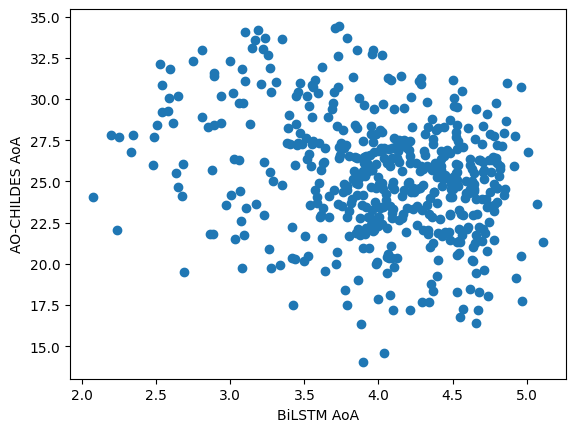

In [14]:
plt.scatter(common_aoas_df['predicted_aoa'].values, common_aoas_df['ao_childes_aoa'])
plt.xlabel("BiLSTM AoA")
plt.ylabel("AO-CHILDES AoA")

In [16]:
pearsonr(
    common_aoas_df['ao_childes_aoa'].values,
    common_aoas_df['predicted_aoa'].values
)

PearsonRResult(statistic=-0.27338006029358086, pvalue=4.695576809219599e-10)

We see negative correlation between AO-CHILDES AoA and the model AoA, but when filtering by predicates, nouns or function words, it becomes positive (around 0.16, but with a higher p value, 0.18 for predicates showing it can't be trusted).

In [17]:
def adj_r2_score(y, y_pred, p):
    n = y.shape[0]
    r2 = r2_score(y, y_pred)
    return 1-((1-r2)*(n-1)/(n-p-1))

In [18]:
model = LinearRegression()
model.fit(common_aoas_df['predicted_aoa'].values.reshape(-1, 1), common_aoas_df['ao_childes_aoa'].values)

LinearRegression()

The R^2 fit is still pretty bad as the data doesn't form a line per se.

In [19]:
adj_r2_score(common_aoas_df['ao_childes_aoa'].values, model.predict(common_aoas_df['predicted_aoa'].values.reshape(-1, 1)), p=1)

0.07288613068085414